In [181]:
#!pip install ucimlrepo

In [182]:
import sys
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import optuna
import statistics
import re
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.feature_selection import SelectFromModel, SequentialFeatureSelector
from ucimlrepo import fetch_ucirepo
from sklearn.utils import class_weight
from functools import partial
import warnings

warnings.filterwarnings('ignore')


In [183]:
sys.path.append(os.path.abspath("/home/bk_anupam/code/ML/ML_UTILS/"))

In [184]:
import train_tabular_utils as tt
import cv_split_utils
import enums
import data_utils

In [185]:
class Config:
    RUN_MODE = "LOCAL"
    RANDOM_SEED = 42
    NUM_FOLDS = 5
    TARGET_COL_NAME = "Target"        
    SCALER = enums.Scaler.StandardScaler
    METRIC = enums.Metrics.ACCURACY
    # These values are more dynamic   
    MODEL_TYPE = enums.ModelName.XGBoost
    NUM_TUNING_TRIALS = 25
    TUNE_ON_SINGLE_FOLD = True
    TRAIN_SINGLE_FOLD = False    
    PERSIST_MODEL = False
    USE_OPENFE_FEATURES = True
    CREATE_MANUAL_FEATURES = True
    USE_ORIGINAL_DATA = True
    NUM_CLASSES = 3
    FEATURE_SELECTION_METHOD = None

COLS_TO_LEAVE = ["id", "Target", "kfold"]
CPU_COUNT = os.cpu_count()

DATA_READPATH = "./data/"
DATA_WRITEPATH = "./output/"
SUBMISSION_FILEPATH = DATA_READPATH
if Config.RUN_MODE == "KAGGLE":    
    DATA_READPATH = "/kaggle/input/playground-series-s4e6/"
    if Config.USE_OPENFE_FEATURES:
        DATA_READPATH = "/kaggle/input/ps4e6-openfe/"
    SUBMISSION_FILEPATH = "/kaggle/input/playground-series-s4e6/"
    DATA_WRITEPATH = "/kaggle/working/"

In [186]:
# fetch original dataset 
predict_students_dropout_and_academic_success = fetch_ucirepo(id=697) 
df_train_orig = predict_students_dropout_and_academic_success.data.features 
df_train_orig[Config.TARGET_COL_NAME] = predict_students_dropout_and_academic_success.data.targets[Config.TARGET_COL_NAME]
# rename column 'Marital Status' to 'Marital status'
df_train_orig = df_train_orig.rename(columns={'Marital Status': 'Marital status'})

In [198]:
# no missing values in original data
na_orig = df_train_orig.isna().sum()
na_orig.loc[na_orig > 0]

Series([], dtype: int64)

In [199]:
if Config.USE_OPENFE_FEATURES and not Config.USE_ORIGINAL_DATA:
    print("using generated openfe features only on train data")
    df_train = pd.read_csv(DATA_READPATH + "train_openfe.csv")    
    df_test = pd.read_csv(DATA_READPATH + "test_openfe.csv")
elif Config.USE_OPENFE_FEATURES and Config.USE_ORIGINAL_DATA:
    print("using generated openfe features on both train and original data")
    df_train = pd.read_csv(DATA_READPATH + "train_orig_openfe.csv")    
    df_test = pd.read_csv(DATA_READPATH + "test_orig_openfe.csv")
else:    
    df_train = pd.read_csv(DATA_READPATH + "train.csv")
    df_train = df_train.drop("id", axis=1)    
    df_test = pd.read_csv(DATA_READPATH + "test.csv")
    df_test = df_test.drop("id", axis=1)
    if Config.USE_ORIGINAL_DATA:
        # add df_train_orig rows to df_train
        df_train = pd.concat([df_train, df_train_orig], axis=0, ignore_index=True)

using generated openfe features on both train and original data


In [200]:
# Label encoding of target values
le = LabelEncoder()
le.fit(df_train[Config.TARGET_COL_NAME])
df_train[Config.TARGET_COL_NAME] = le.transform(df_train[Config.TARGET_COL_NAME])
list(le.classes_)

['Dropout', 'Enrolled', 'Graduate']

In [201]:
# Dropout = 0.33, Enrolled = 0.2, Graduate = 0.47
# Increase the weight of the minority class for model to focus more on the minority class
# calculate class weights
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(df_train.Target), y=df_train.Target)
print(class_weights)

[1.00986887 1.71480022 0.7009604 ]


In [202]:
model_static_params = {
    enums.ModelName.XGBoost: {
        #"objective": "multi:softmax",        
        "seed": Config.RANDOM_SEED,
        "verbosity": 0,
        "num_class": 3,
        #"eval_metric": "merror",
        # level 2 tuning
        'subsample': 0.5067,
        'early_stopping_rounds': 260,
        'reg_alpha': 0.59718,
        'colsample_bytree': 0.7289930512882908
    },
    enums.ModelName.LGBM: {
        "objective": "multiclass",
        "metric": 'multi_logloss',
        "verbosity": -1,    # <0: fatal, =0: error (warn), =1: info, >1: debug
        "boosting_type": "gbdt",
        "num_class": 3,
    },
    enums.ModelName.CatBoost: {
        "objective": "MultiClass",
        "verbose": 0,
        "random_seed": Config.RANDOM_SEED,
        "eval_metric": "Accuracy",
        'grow_policy':  'Lossguide',
        #'bootstrap_type': 'Poisson',
        #'class_weights': class_weights,
        'task_type': 'CPU'
    },
    enums.ModelName.RandomForest: {
        "random_state": Config.RANDOM_SEED,
        "n_jobs": -1
    }
}

In [203]:
# For RandomForest
# tuned_model_params = {'n_estimators': 1300, 'max_depth': 17, 'min_samples_leaf': 3, 'min_samples_split': 3, 'max_features': 'sqrt'}
# For CatBoost
# tuned_model_params = {'learning_rate': 0.45126024670762294, 'n_estimators': 3700, 'max_depth': 7, 'min_data_in_leaf': 73, 'colsample_bylevel': 0.8908705634626486, 'num_leaves': 120, 'reg_lambda': 98.46961225632553, 'random_strength': 0.016359736302592447, 'early_stopping_rounds': 210, 'max_bin': 253}
# For XGBoost
# tuned_model_params = {'n_estimators': 1400, 'learning_rate': 0.10270166896064774, 'max_depth': 30, 'min_child_weight': 7, 'gamma': 4.123490349502186, 'subsample': 0.5067185283456936, 'colsample_bytree': 0.7289930512882908, 'reg_alpha': 0.5971832077526927, 'reg_lambda': 9.433125479981229, 'early_stopping_rounds': 260}
# For LGBM
# tuned_model_params = {'learning_rate': 0.050431114227825063, 'n_estimators': 1500, 'max_depth': 6, 'min_data_in_leaf': 92, 'min_child_weight': 6, 'num_leaves': 428, 'reg_lambda': 130.60718838770154, 'early_stopping_rounds': 365, 'subsample': 0.8586720764925466, 'colsample_bytree': 0.5962542688745494, 'reg_alpha': 0.5737569015209647}
# For LogisticRegression
# tuned_model_params =  {'C': 38.49119721953264, 'penalty': 'l2'}

tuned_model_params = None

In [204]:
def process_col_name(cols_list):
    processed_cols_list = []
    for item in cols_list:
        # Remove round brackets but keep the text inside them
        item_no_brackets = re.sub(r'[\(\)]', '', item)
        # Remove single quotes
        item_no_quotes = item_no_brackets.replace("'", "")
        # Replace forward slash with underscore
        item_no_slash = item_no_quotes.replace('/', '_')
        # Replace spaces with underscores
        item_processed = item_no_slash.replace(' ', '_')        
        # Append to the processed list
        processed_cols_list.append(item_processed)
    return processed_cols_list

In [205]:
train_cols_list = df_train.columns.to_list()
test_cols_list = df_test.columns.to_list()
train_processed_cols_list = process_col_name(train_cols_list)
test_processed_cols_list = process_col_name(test_cols_list)
df_train.columns = train_processed_cols_list
df_test.columns = test_processed_cols_list

In [206]:
# feature engineering
def create_features(df):
    # (Tuition_fees_up_to_date*Curricular_units_2nd_sem_approved)
    df["f_1"] = df["Tuition_fees_up_to_date"] * df["Curricular_units_2nd_sem_approved"]
    # (Curricular_units_1st_sem_approved+Curricular_units_2nd_sem_approved)
    df["f_2"] = df["Curricular_units_1st_sem_approved"] + df["Curricular_units_2nd_sem_approved"]
    # (Curricular_units_2nd_sem_grade*Curricular_units_2nd_sem_approved)
    df["f_3"] = df["Curricular_units_2nd_sem_grade"] * df["Curricular_units_2nd_sem_approved"]
    # (Curricular_units_2nd_sem_grade+Curricular_units_2nd_sem_approved)
    df["f_4"] = df["Curricular_units_2nd_sem_grade"] + df["Curricular_units_2nd_sem_approved"]
    # (Curricular_units_2nd_sem_grade+Scholarship_holder)
    df["f_5"] = df["Curricular_units_2nd_sem_grade"] + df["Scholarship_holder"]
    # (Curricular_units_1st_sem_grade+Scholarship_holder)
    df["f_6"] = df["Curricular_units_1st_sem_grade"] + df["Scholarship_holder"]
    # (Curricular_units_2nd_sem_enrolled-Curricular_units_2nd_sem_approved)
    df["f_7"] = df["Curricular_units_2nd_sem_enrolled"] - df["Curricular_units_2nd_sem_approved"]
    # (Curricular_units_1st_sem_enrolled-Curricular_units_2nd_sem_approved)
    df["f_8"] = df["Curricular_units_1st_sem_enrolled"] - df["Curricular_units_2nd_sem_approved"]
    # (Curricular_units_2nd_sem_grade-Curricular_units_1st_sem_evaluations)
    df["f_9"] = df["Curricular_units_2nd_sem_grade"] - df["Curricular_units_1st_sem_evaluations"]
    # (Curricular_units_1st_sem_grade/Age_at_enrollment)
    df["f_10"] = df["Curricular_units_1st_sem_grade"] / df["Age_at_enrollment"]
    # (Curricular_units_1st_sem_evaluations-Curricular_units_2nd_sem_approved)
    df["f_11"] = df["Curricular_units_1st_sem_evaluations"] - df["Curricular_units_2nd_sem_approved"]
    # GroupByThenRank(Curricular_units_2nd_sem_approved,Curricular_units_1st_sem_enrolled)    
    df["f_12"] = df.groupby('Curricular_units_1st_sem_enrolled')['Curricular_units_2nd_sem_approved'].rank(method="dense", ascending=False)
    # GroupByThenRank(Curricular_units_2nd_sem_approved,Mothers_occupation)
    df["f_13"] = df.groupby('Mothers_occupation')['Curricular_units_2nd_sem_approved'].rank(method="dense", ascending=False)
    # GroupByThenRank(Scholarship_holder,Age_at_enrollment)
    df["f_14"] = df.groupby('Age_at_enrollment')['Scholarship_holder'].rank(method="dense", ascending=False)
    # GroupByThenRank(Scholarship_holder,Curricular_units_2nd_sem_approved)
    df["f_15"] = df.groupby('Curricular_units_2nd_sem_approved')['Scholarship_holder'].rank(method="dense", ascending=False)
    # CombineThenFreq(Course,Curricular_units_1st_sem_approved)
    df["f_16"] = df.groupby('Course')['Curricular_units_1st_sem_approved'].transform('count')
    return df

In [207]:
if Config.CREATE_MANUAL_FEATURES:
    df_train['Unempl_Infl_GDP'] = df_train['Unemployment_rate']*df_train['Inflation_rate']*df_train['GDP']
    df_test['Unempl_Infl_GDP'] = df_test['Unemployment_rate']*df_test['Inflation_rate']*df_test['GDP']

In [208]:
na_val = df_train.isna().sum()
null_features = na_val.loc[na_val > 0].index.values.tolist()
print("null_features; ", null_features)

['autoFE_f_1',
 'autoFE_f_2',
 'autoFE_f_3',
 'autoFE_f_5',
 'autoFE_f_6',
 'autoFE_f_7',
 'autoFE_f_10',
 'autoFE_f_13',
 'autoFE_f_15',
 'autoFE_f_16',
 'autoFE_f_17',
 'autoFE_f_18',
 'autoFE_f_19',
 'autoFE_f_23',
 'autoFE_f_31',
 'autoFE_f_37',
 'autoFE_f_42',
 'autoFE_f_47']

In [209]:
cat_features = ['Marital_status', 'Application_mode', 'Course', 'Daytime_evening_attendance', 'Previous_qualification',
    'Nacionality', 'Mothers_qualification', 'Fathers_qualification', 'Mothers_occupation', 'Fathers_occupation', 'Displaced',
    'Educational_special_needs', 'Debtor', 'Tuition_fees_up_to_date','Gender', 'Scholarship_holder', 'International']

In [210]:
cont_features = [x for x in df_train.dtypes[df_train.dtypes == "float"].index.values if x not in null_features]
int_features = [x for x in df_train.dtypes[df_train.dtypes == "int"].index.values if x not in COLS_TO_LEAVE+null_features]
feature_cols = df_test.columns.to_list()
feature_cols_after_fe = [x for x in df_train.columns if x not in COLS_TO_LEAVE+null_features]

In [211]:
# for categorical features find the categories to be used for one hot encoding
int_feature_categories = []
for int_feature in int_features:
    int_feature_categories.append(sorted(df_train[int_feature].unique()))

In [212]:
print(f"len(feature_cols_after_fe)={len(feature_cols_after_fe)}")
print(feature_cols_after_fe)

len(feature_cols_after_fe)=69
['Marital_status', 'Application_mode', 'Application_order', 'Course', 'Daytime_evening_attendance', 'Previous_qualification', 'Previous_qualification_grade', 'Nacionality', 'Mothers_qualification', 'Fathers_qualification', 'Mothers_occupation', 'Fathers_occupation', 'Admission_grade', 'Displaced', 'Educational_special_needs', 'Debtor', 'Tuition_fees_up_to_date', 'Gender', 'Scholarship_holder', 'Age_at_enrollment', 'International', 'Curricular_units_1st_sem_credited', 'Curricular_units_1st_sem_enrolled', 'Curricular_units_1st_sem_evaluations', 'Curricular_units_1st_sem_approved', 'Curricular_units_1st_sem_grade', 'Curricular_units_1st_sem_without_evaluations', 'Curricular_units_2nd_sem_credited', 'Curricular_units_2nd_sem_enrolled', 'Curricular_units_2nd_sem_evaluations', 'Curricular_units_2nd_sem_approved', 'Curricular_units_2nd_sem_grade', 'Curricular_units_2nd_sem_without_evaluations', 'Unemployment_rate', 'Inflation_rate', 'GDP', 'autoFE_f_0', 'autoFE_f

In [ ]:
# df_train_float = df_train[cont_features]
# df_train_float["type"] = "train"
# df_test_float = df_test[cont_features]
# df_test_float["type"] = "test"
# # concat df_train_float and df_test_float rows
# df_all_float = pd.concat([df_train_float, df_test_float], axis=0, ignore_index=True)
# scaler = StandardScaler()
# df_all_float[cont_features] = scaler.fit_transform(df_all_float)
# df_train[cont_features] = df_all_float[df_all_float["type"] == "train"][cont_features]
# df_test[cont_features] = df_all_float[df_all_float["type"] == "test"][cont_features]

In [213]:
# preprocessing
preprocessor = None
scaler = StandardScaler()
onehot_encoder = OneHotEncoder(sparse_output=False, handle_unknown="ignore", categories=int_feature_categories)
if Config.MODEL_TYPE == enums.ModelName.LogisticRegression:
    preprocessor = ColumnTransformer(
        transformers=[                
            ("scaler", scaler, feature_cols_after_fe),
            #("onehot", onehot_encoder, int_features),                
        ], remainder="passthrough"
    )
else:
    preprocessor = ColumnTransformer(
        transformers=[                
            ("scaler", scaler, cont_features)     
        ], remainder="passthrough"
    )

In [214]:
def get_lgbm_tuning_params(trial):    
    params_dynamic = {
        'learning_rate': trial.suggest_float('learning_rate', 1e-2, 1.0, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 500, 5000, step=100),
        'max_depth': trial.suggest_int('max_depth', 4, 20),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1),
        'num_leaves': trial.suggest_int('num_leaves', 4, 256, step=4),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 1),
        'reg_lambda': trial.suggest_float('reg_lambda', 1, 200),
        'early_stopping_rounds': trial.suggest_int('early_stopping_rounds', 50, 500, step=20)
    }
    return {**model_static_params[enums.ModelName.LGBM], **params_dynamic}

In [215]:
def get_xgb_tuning_params(trial):
    params_dynamic = {            
            'n_estimators': trial.suggest_int('n_estimators', 1000, 5000, step=100),
            'learning_rate': trial.suggest_float('learning_rate', 1e-2, 1.0, log=True),
            'max_depth': trial.suggest_int('max_depth', 4, 32),
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
            'gamma': trial.suggest_float('gamma', 0, 10),
            'subsample': trial.suggest_float('subsample', 0.5, 1),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1),
            'reg_alpha': trial.suggest_float('reg_alpha', 0, 1),
            'reg_lambda': trial.suggest_float('reg_lambda', 1, 200),
            'early_stopping_rounds': trial.suggest_int('early_stopping_rounds', 100, 500, step=20)
        }
    return {**model_static_params[enums.ModelName.XGBoost], **params_dynamic}

In [ ]:
def get_xgb_tuning_params_level2(trial):
    params_dynamic = {
            "objective": trial.suggest_categorical("objective", ["multi:softmax", "multi:softprob"]),
            "eval_metric": trial.suggest_categorical("eval_metric", ["mlogloss", "merror", "auc"]),            
            'n_estimators': trial.suggest_int('n_estimators', 1000, 2500, step=25),
            'learning_rate': trial.suggest_float('learning_rate', 1e-2, 0.5, log=True),
            'max_depth': trial.suggest_int('max_depth', 16, 64),
            'min_child_weight': trial.suggest_int('min_child_weight', 5, 15),
            'gamma': trial.suggest_float('gamma', 0, 10),
            #'subsample': trial.suggest_float('subsample', 0.5, 1),
            #'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1),
            #'reg_alpha': trial.suggest_float('reg_alpha', 0, 1),
            'reg_lambda': trial.suggest_float('reg_lambda', 1, 20),
            #'early_stopping_rounds': trial.suggest_int('early_stopping_rounds', 100, 500, step=20)
        }
    return {**model_static_params[enums.ModelName.XGBoost], **params_dynamic}

In [216]:
def get_catboost_tuning_params(trial):
    params_dynamic = {
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 1.0, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 100, 5000, step=50),
        'max_depth': trial.suggest_int('max_depth', 4, 16),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 5, 100),
        #'subsample': trial.suggest_float('subsample', 0.5, 1),
        # comment colsample_bylevel for GPU training
        'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.5, 1),
        'num_leaves': trial.suggest_int('num_leaves', 4, 256, step=4),
        'reg_lambda': trial.suggest_float('reg_lambda', 1, 100),
        'random_strength': trial.suggest_loguniform('random_strength', 0.01, 10),
        'early_stopping_rounds': trial.suggest_int('early_stopping_rounds', 50, 500, step=20),
        'max_bin': trial.suggest_int('max_bin', 32, 255)
    }
    return {**model_static_params[enums.ModelName.CatBoost], **params_dynamic}

In [217]:
def get_model_tuning_params(trial, model_name):
    if model_name == enums.ModelName.LogisticRegression:
        penalty = ['l1', 'l2']
        return {        
            "C": trial.suggest_loguniform("C", 1e-3, 100),
            "penalty": trial.suggest_categorical("penalty", penalty)
        }    
    if model_name == enums.ModelName.RandomForest:
        return {        
            "n_estimators": trial.suggest_int("n_estimators", 200, 3000, step=100),
            "max_depth": trial.suggest_int("max_depth", 10, 30),
            "min_samples_leaf": trial.suggest_int("min_samples_leaf", 2, 16),
            "min_samples_split": trial.suggest_int("min_samples_split", 2, 16),
            "max_features": trial.suggest_categorical("max_features", ["log2", "sqrt", None])
        }
    if model_name == enums.ModelName.CatBoost:
        return get_catboost_tuning_params(trial)
    if model_name == enums.ModelName.XGBoost:
        return get_xgb_tuning_params_level2(trial) 
    if model_name == enums.ModelName.LGBM:
        return get_lgbm_tuning_params(trial)   

In [218]:
def hyperparams_tuning_objective(trial, model_name, preprocessor, df,  
                                 feature_cols, metric, target_col_name, single_fold=False, num_folds=5):               
    model_params = get_model_tuning_params(trial, model_name)    
    fold_metrics_model, _, _ = tt.train_and_validate(
                                        model_name=model_name,
                                        model_params=model_params,
                                        preprocessor=preprocessor,
                                        df=df,
                                        feature_cols=feature_cols,
                                        target_col_name=target_col_name,
                                        metric=metric,
                                        single_fold=single_fold,
                                        num_folds=num_folds,
                                        suppress_print=True,
                                        num_classes=Config.NUM_CLASSES
                                    )
    fold_metrics = [x[0] for x in fold_metrics_model]
    mean_metric = statistics.mean(fold_metrics)                
    return mean_metric

In [219]:
def tune_model_params(study_name, study_direction, num_trials, model_name, 
                      preprocessor, df,  feature_cols, metric, target_col_name, 
                      single_fold=False, num_folds=5):
    model_params_tuning_obj_partial = partial(
        hyperparams_tuning_objective,
        model_name=model_name,        
        preprocessor=preprocessor,        
        df=df,
        feature_cols=feature_cols,
        metric=metric,
        target_col_name=target_col_name,
        single_fold=single_fold,
        num_folds=num_folds
    )
    study = optuna.create_study(direction=study_direction, study_name=study_name)
    study.optimize(model_params_tuning_obj_partial, n_trials=num_trials)
    best_trial = study.best_trial
    print(f"Best trial: number = {best_trial.number}, value = {best_trial.value}, params = {best_trial.params}")
    return best_trial.params

In [220]:
df_train = cv_split_utils.strat_kfold_dataframe(df_train, 
                                                target_col_name=Config.TARGET_COL_NAME, 
                                                random_state=Config.RANDOM_SEED, 
                                                num_folds=Config.NUM_FOLDS)

In [221]:
if tuned_model_params is None:
    #df = df_train.sample(frac=0.1, random_state=Config.RANDOM_SEED)
    tuned_model_params = tune_model_params(
                            study_name=Config.MODEL_TYPE + "_ModelTuning", 
                            study_direction="maximize",
                            num_trials=Config.NUM_TUNING_TRIALS,
                            model_name=Config.MODEL_TYPE,
                            preprocessor=preprocessor,
                            df=df_train,
                            feature_cols=feature_cols_after_fe,
                            metric=Config.METRIC,
                            target_col_name=Config.TARGET_COL_NAME,
                            single_fold=Config.TUNE_ON_SINGLE_FOLD,
                            num_folds=Config.NUM_FOLDS
                    )

In [222]:
model_params = None
params_static = model_static_params.get(Config.MODEL_TYPE)
if params_static is not None and tuned_model_params is not None:
    model_params = {**model_static_params[Config.MODEL_TYPE], **tuned_model_params}
else:
    model_params = tuned_model_params

In [223]:
%%time
fold_metrics_model, df_oof_preds, preprocessor = tt.train_and_validate(
        model_name=Config.MODEL_TYPE,
        model_params=model_params,
        preprocessor=preprocessor,
        df=df_train,
        feature_cols=feature_cols_after_fe,
        target_col_name=Config.TARGET_COL_NAME,
        metric=Config.METRIC,
        single_fold=Config.TRAIN_SINGLE_FOLD,
        num_folds=Config.NUM_FOLDS,
        suppress_print=False,
        num_classes=Config.NUM_CLASSES
)

Fold 0 - LightGBM - ACCURACY : 0.8295138674408549
Fold 1 - LightGBM - ACCURACY : 0.8218543455432701
Fold 2 - LightGBM - ACCURACY : 0.8241289844329133
Fold 3 - LightGBM - ACCURACY : 0.8254262416604893
Fold 4 - LightGBM - ACCURACY : 0.8251173708920188
LightGBM metric=ACCURACY CV score = 0.8252081737540461
LightGBM Mean ACCURACY = 0.8252081619939092, std = 0.002490285531972206
CPU times: user 1h 46s, sys: 42.7 s, total: 1h 1min 29s
Wall time: 16min 5s


In [224]:
from sklearn.metrics import accuracy_score, f1_score

def get_model_stats(model_name):
    target_classes = np.array(["Dropout", "Enrolled", "Graduate"])    
    oof_cols = [f"oof_preds_proba_{i}" for i in range(Config.NUM_CLASSES)]
    model_preds_proba = df_oof_preds[oof_cols].to_numpy()
    model_preds = np.argmax(model_preds_proba, axis=1)
    model_accuracy = accuracy_score(df_oof_preds[Config.TARGET_COL_NAME], model_preds)
    model_f1 = f1_score(df_oof_preds[Config.TARGET_COL_NAME], model_preds, average='macro')
    print(f"{model_name} OOF Accuracy: {model_accuracy}")
    print(f"{model_name} OOF F1 Score: {model_f1}")
    model_cm = confusion_matrix(df_oof_preds[Config.TARGET_COL_NAME], model_preds)
    model_cm_percentage = model_cm / model_cm.sum(axis=1, keepdims=True) * 100
    print(classification_report(df_oof_preds[Config.TARGET_COL_NAME].values, model_preds, target_names=target_classes))
    disp = ConfusionMatrixDisplay(confusion_matrix=model_cm_percentage, display_labels=target_classes)
    disp.plot()
    plt.show()

LightGBM OOF Accuracy: 0.8252081737540461
LightGBM OOF F1 Score: 0.7858514309195095
              precision    recall  f1-score   support

     Dropout       0.88      0.84      0.86     26717
    Enrolled       0.65      0.59      0.62     15734
    Graduate       0.85      0.91      0.88     38491

    accuracy                           0.83     80942
   macro avg       0.79      0.78      0.79     80942
weighted avg       0.82      0.83      0.82     80942



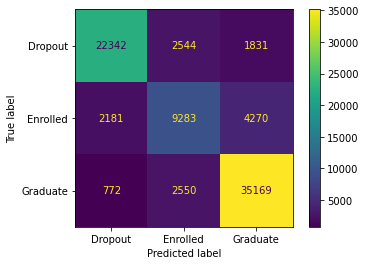

In [225]:
get_model_stats(Config.MODEL_TYPE)

In [226]:
tt.persist(
    model_name=Config.MODEL_TYPE, 
    fold_metrics_model=fold_metrics_model, 
    df_oof_preds=df_oof_preds, 
    persist_model=Config.PERSIST_MODEL, 
    output_path=DATA_WRITEPATH
)

In [227]:
test_preds_proba, test_preds = tt.get_test_preds_clf(fold_metrics_model, df_test, feature_cols_after_fe, 
                                                     preprocessor=preprocessor, num_folds=Config.NUM_FOLDS)
# convert test_preds to string using labelencoder
test_preds_final = le.inverse_transform(test_preds)
df_test_preds = pd.DataFrame()
for i in range(Config.NUM_CLASSES):
    df_test_preds[f"test_preds_proba_{i}"] = test_preds_proba[:, i]
df_test_preds["test_preds"] = test_preds
df_test_preds.to_csv(DATA_WRITEPATH + f'df_test_preds_{Config.MODEL_TYPE}.csv',index=False)
df_submission = pd.read_csv(SUBMISSION_FILEPATH + 'sample_submission.csv')
df_submission[Config.TARGET_COL_NAME]= test_preds_final
df_submission.to_csv(DATA_WRITEPATH + f'submission_{Config.MODEL_TYPE}.csv',index=False)
df_submission.head()

In [228]:
# Define a function to extract the part after '__' (vectorized for speed)
def extract_after_delimiter(text):
    return text.split("__", 1)[1] if len(text.split("__")) > 1 else text

features = preprocessor.get_feature_names_out()
# Apply the function to the feature names using lambda
features = list(map(extract_after_delimiter, features))
len(features)

69

In [229]:
def get_feature_importance(model, features):
    df_feature_imp = pd.DataFrame()
    df_feature_imp["f_name"] = features
    df_feature_imp["f_imp"] = model.feature_importances_
    df_feature_imp = df_feature_imp.sort_values(by="f_imp", ascending=False)
    return df_feature_imp

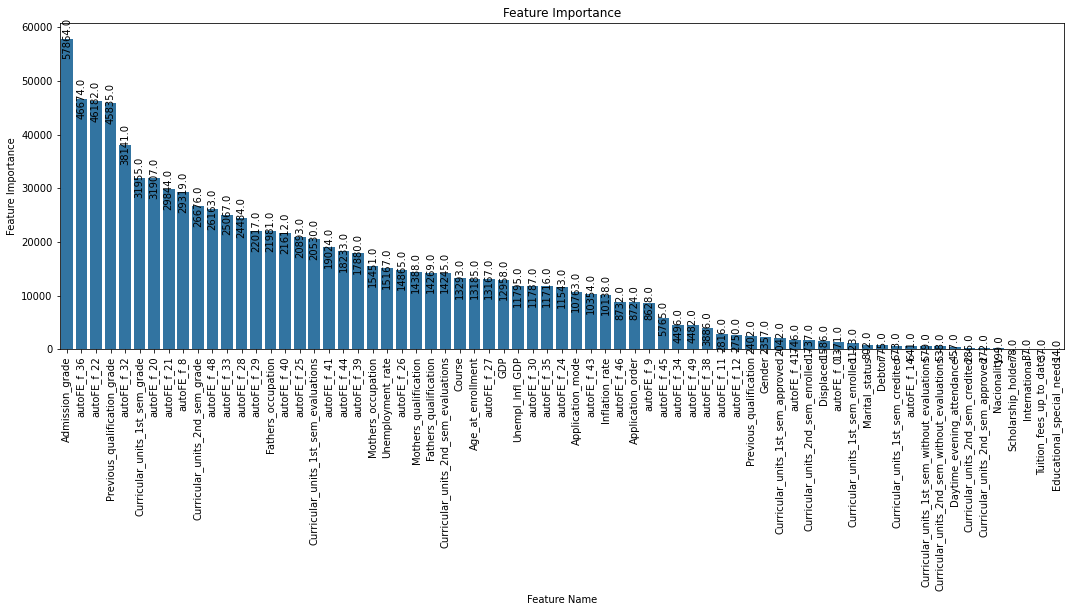

In [230]:
if Config.MODEL_TYPE in [enums.ModelName.CatBoost, enums.ModelName.LGBM, enums.ModelName.XGBoost, 
                         enums.ModelName.RandomForest]:
    df_feature_imp = get_feature_importance(fold_metrics_model[0][1], features)
    df_feature_imp.to_csv(DATA_WRITEPATH + f"{Config.MODEL_TYPE}_feature_imp_orig_openfe.csv", index=False)
    data_utils.plot_feature_importance(df_feature_imp, fig_size=(18, 6))

In [231]:
def get_preprocessor(cur_features):
    cur_cont_features = [x for x in df_train[cur_features].dtypes[df_train[cur_features].dtypes == "float"].index.values 
                         if x not in null_features]
    cur_scaler = StandardScaler()
    preprocessor = ColumnTransformer(
        transformers=[                
            ("scaler", cur_scaler, cur_cont_features),        
        ], remainder="passthrough"
    )
    return preprocessor

In [232]:
def get_candidate_features(df_feature_imp, feature_selection_method):
    if feature_selection_method == "forward":
        # all remanining features are candidate features (get rows from df_feature_imp that are not in base_features)
        candidate_features = df_feature_imp.iloc[30:, :]["f_name"].values
    else:
        # for backward feature selection features from last to 30th are candidate features
        candidate_features = df_feature_imp.iloc[30:]["f_name"].values
        candidate_features = candidate_features[::-1]
    return candidate_features

In [233]:
# select the top 30 features as the base features
# the set of constant features to be included in the model irrespective of the feature selection method
if Config.FEATURE_SELECTION_METHOD is not None:
    if Config.FEATURE_SELECTION_METHOD == "forward":
        base_features = df_feature_imp.head(30).f_name.values
    else:
        # for backward selection the entire feature set is the starting point
        base_features = df_feature_imp["f_name"].values    
    print(f"len(base_features) = {len(base_features)} base_features = {base_features}")    
    best_score = 0.0
    base_preprocessor = get_preprocessor(base_features)
    base_val_score = tt.train_validate_fold(
            fold=0, 
            model_name=Config.MODEL_TYPE, 
            model_params=model_params, 
            preprocessor=base_preprocessor, 
            df=df_train, 
            feature_cols=base_features, 
            metric=Config.METRIC, 
            target_col_name=Config.TARGET_COL_NAME, 
            num_classes=Config.NUM_CLASSES
        )
    print(f"\n base_val_score = {base_val_score}")
    best_score = base_val_score
    candidate_features = get_candidate_features(df_feature_imp, Config.FEATURE_SELECTION_METHOD)
    print(f"\n len(candidate_features)={len(candidate_features)} candidate_features = {candidate_features}")
    selected_features = base_features

len(base_features) = 69 base_features = ['Admission_grade' 'autoFE_f_36' 'autoFE_f_22'
 'Previous_qualification_grade' 'autoFE_f_32'
 'Curricular_units_1st_sem_grade' 'autoFE_f_20' 'autoFE_f_21' 'autoFE_f_8'
 'Curricular_units_2nd_sem_grade' 'autoFE_f_48' 'autoFE_f_33'
 'autoFE_f_28' 'autoFE_f_29' 'Fathers_occupation' 'autoFE_f_40'
 'autoFE_f_25' 'Curricular_units_1st_sem_evaluations' 'autoFE_f_41'
 'autoFE_f_44' 'autoFE_f_39' 'Mothers_occupation' 'Unemployment_rate'
 'autoFE_f_26' 'Mothers_qualification' 'Fathers_qualification'
 'Curricular_units_2nd_sem_evaluations' 'Course' 'Age_at_enrollment'
 'autoFE_f_27' 'GDP' 'Unempl_Infl_GDP' 'autoFE_f_30' 'autoFE_f_35'
 'autoFE_f_24' 'Application_mode' 'autoFE_f_43' 'Inflation_rate'
 'autoFE_f_46' 'Application_order' 'autoFE_f_9' 'autoFE_f_45'
 'autoFE_f_34' 'autoFE_f_49' 'autoFE_f_38' 'autoFE_f_11' 'autoFE_f_12'
 'Previous_qualification' 'Gender' 'Curricular_units_1st_sem_approved'
 'autoFE_f_4' 'Curricular_units_2nd_sem_enrolled' 'Displaced

In [234]:
if Config.FEATURE_SELECTION_METHOD is not None:
    unselected_features = []
    print(f"FEATURE SELECTION METHOD = {Config.FEATURE_SELECTION_METHOD}")
    for feature in candidate_features:
        if Config.FEATURE_SELECTION_METHOD == "forward":
            # add the feature to base_features
            cur_features = np.append(selected_features, feature)
        else:
            # remove the feature from base_features
            cur_features = np.delete(selected_features, np.where(selected_features == feature))
        cur_preprocessor = get_preprocessor(cur_features)
        cur_val_score = tt.train_validate_fold(
            fold=0, 
            model_name=Config.MODEL_TYPE, 
            model_params=model_params, 
            preprocessor=cur_preprocessor, 
            df=df_train, 
            feature_cols=cur_features, 
            metric=Config.METRIC, 
            target_col_name=Config.TARGET_COL_NAME, 
            num_classes=Config.NUM_CLASSES
        )
        if cur_val_score > best_score:
            print(f"feature selected = {feature} | cur_val_score = {cur_val_score} | best_score = {best_score}")
            if Config.FEATURE_SELECTION_METHOD == "forward":
                selected_features = np.append(selected_features, feature)
            else:
                selected_features = np.delete(selected_features, np.where(selected_features == feature))
            best_score = cur_val_score
        else:
            print(f"feature not selected = {feature} | cur_val_score = {cur_val_score} | best_score = {best_score}")
            unselected_features.append(feature)
    print(f"len(selected_features) = {len(selected_features)}")
    print(f"selected_features = {selected_features}")

FEATURE SELECTION METHOD = backward
feature selected = Educational_special_needs | cur_val_score = 0.8295138674408549 | best_score = 0.8294520971029712
feature not selected = Tuition_fees_up_to_date | cur_val_score = 0.8293903267650874 | best_score = 0.8295138674408549
feature not selected = International | cur_val_score = 0.829019704737785 | best_score = 0.8295138674408549
feature selected = Scholarship_holder | cur_val_score = 0.8296991784545061 | best_score = 0.8295138674408549
feature selected = Nacionality | cur_val_score = 0.8306257335227624 | best_score = 0.8296991784545061
feature not selected = Curricular_units_2nd_sem_approved | cur_val_score = 0.828525542034715 | best_score = 0.8306257335227624
feature selected = Curricular_units_2nd_sem_credited | cur_val_score = 0.8308728148742973 | best_score = 0.8306257335227624
feature not selected = Daytime_evening_attendance | cur_val_score = 0.8299462598060411 | best_score = 0.8308728148742973
feature not selected = Curricular_units_

In [235]:
# from fwd_feature_selector import VerboseSequentialFeatureSelector

# fs_model = tt.get_model(Config.MODEL_TYPE, model_params, Config.METRIC)
# verbose_sfs = VerboseSequentialFeatureSelector(fs_model, 
#                                                n_features_to_select="auto", 
#                                                direction="forward",
#                                                scoring="accuracy",
#                                                n_jobs=-1)

# X_train = df_train[features].to_numpy()
# y_train = df_train[Config.TARGET_COL_NAME].to_numpy()
# # Fit the custom SequentialFeatureSelector to the training data
# verbose_sfs.fit(X_train, y_train)
# # Get the selected features
# selected_features = verbose_sfs.get_support(indices=True)
# print("Selected features indices:", selected_features)

In [236]:
# # performing feature selection by removing bottom 8 features leads to an improvment in cv score for catboost
# # from 0.82996 to 0.83129. Forward feature selection algorithm might help to improve cv score further
# df_feature_imp = df_feature_imp.head(60)
# feature_cols_new = df_feature_imp.f_name.values

In [237]:
if Config.FEATURE_SELECTION_METHOD is not None:
    cont_features1 = [x for x in df_train[selected_features].dtypes[df_train[selected_features].dtypes == "float"].index.values 
                      if x not in null_features]
    scaler1 = StandardScaler()
    preprocessor1 = ColumnTransformer(
        transformers=[                
            ("scaler", scaler1, cont_features1),        
        ], remainder="passthrough"
    )

In [238]:
if Config.FEATURE_SELECTION_METHOD is not None:
        fold_metrics_model1, df_oof_preds1, preprocessor1 = tt.train_and_validate(
                model_name=Config.MODEL_TYPE,
                model_params=model_params,
                preprocessor=preprocessor1,
                df=df_train,
                feature_cols=selected_features,
                target_col_name=Config.TARGET_COL_NAME,
                metric=Config.METRIC,
                single_fold=Config.TRAIN_SINGLE_FOLD,
                num_folds=Config.NUM_FOLDS,
                suppress_print=False,
                num_classes=Config.NUM_CLASSES
        )

Fold 0 - LightGBM - ACCURACY : 0.8308728148742973
Fold 1 - LightGBM - ACCURACY : 0.8249428624374575
Fold 2 - LightGBM - ACCURACY : 0.8235112428959723
Fold 3 - LightGBM - ACCURACY : 0.8255497899678774
Fold 4 - LightGBM - ACCURACY : 0.8261057573511242
LightGBM metric=ACCURACY CV score = 0.8261965357910602
LightGBM Mean ACCURACY = 0.8261964935053457, std = 0.002493054421800091


In [239]:
if Config.FEATURE_SELECTION_METHOD is not None:
    df_oof_preds1.to_csv(DATA_WRITEPATH + f"df_val_preds_{Config.MODEL_TYPE}_fs.csv")
    print(f"Saved validation data predictions to df_val_preds_{Config.MODEL_TYPE}_fs.csv")  

Saved validation data predictions to df_val_preds_LightGBM_fs.csv


In [240]:
if Config.FEATURE_SELECTION_METHOD is not None:
    test_preds_proba1, test_preds1 = tt.get_test_preds_clf(fold_metrics_model1, df_test, selected_features, 
                                                        preprocessor=preprocessor1, num_folds=Config.NUM_FOLDS)
    # convert test_preds to string using labelencoder
    test_preds_final1 = le.inverse_transform(test_preds1)
    df_test_preds1 = pd.DataFrame()
    for i in range(Config.NUM_CLASSES):
        df_test_preds1[f"test_preds_proba_{i}"] = test_preds_proba1[:, i]
    df_test_preds1["test_preds"] = test_preds1
    df_test_preds1.to_csv(DATA_WRITEPATH + f'df_test_preds_{Config.MODEL_TYPE}_fs.csv',index=False)
    df_submission1 = pd.read_csv(SUBMISSION_FILEPATH + 'sample_submission.csv')
    df_submission1[Config.TARGET_COL_NAME] = test_preds_final1
    df_submission1.to_csv(DATA_WRITEPATH + f'submission_{Config.MODEL_TYPE}_fs.csv',index=False)
    df_submission1.head()

test_X shape: (51012, 65)
test_preds_proba shape: (51012, 3)
test_preds shape: (51012,)
